Predicting Heart Disease

In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [5]:
file = "heart.csv"
df = pd.read_csv(file)

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,OldPeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
print(df.dtypes)
df.dtypes.value_counts()


Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
OldPeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
Name: count, dtype: int64

7 features are numerical and 5 features are categorical. However, the features FastingBS and HeartDisease are both categorical aswell.

Numerical Features: 5
Categorical Features: 7

In [7]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,OldPeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Average Age of Patients: ~53.

Median for Cholesterol is higher than its mean by around 25mm/dl.

RestingBP and Cholesterol have a min of 0 which is unlikey.

In [8]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
OldPeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No missing values.

In [9]:
df.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [10]:
df["FastingBS"].unique(), df["HeartDisease"].unique()

(array([0, 1]), array([0, 1]))

All categorical features, FastingBS and HeartDisease being categorical as they only have binary values.


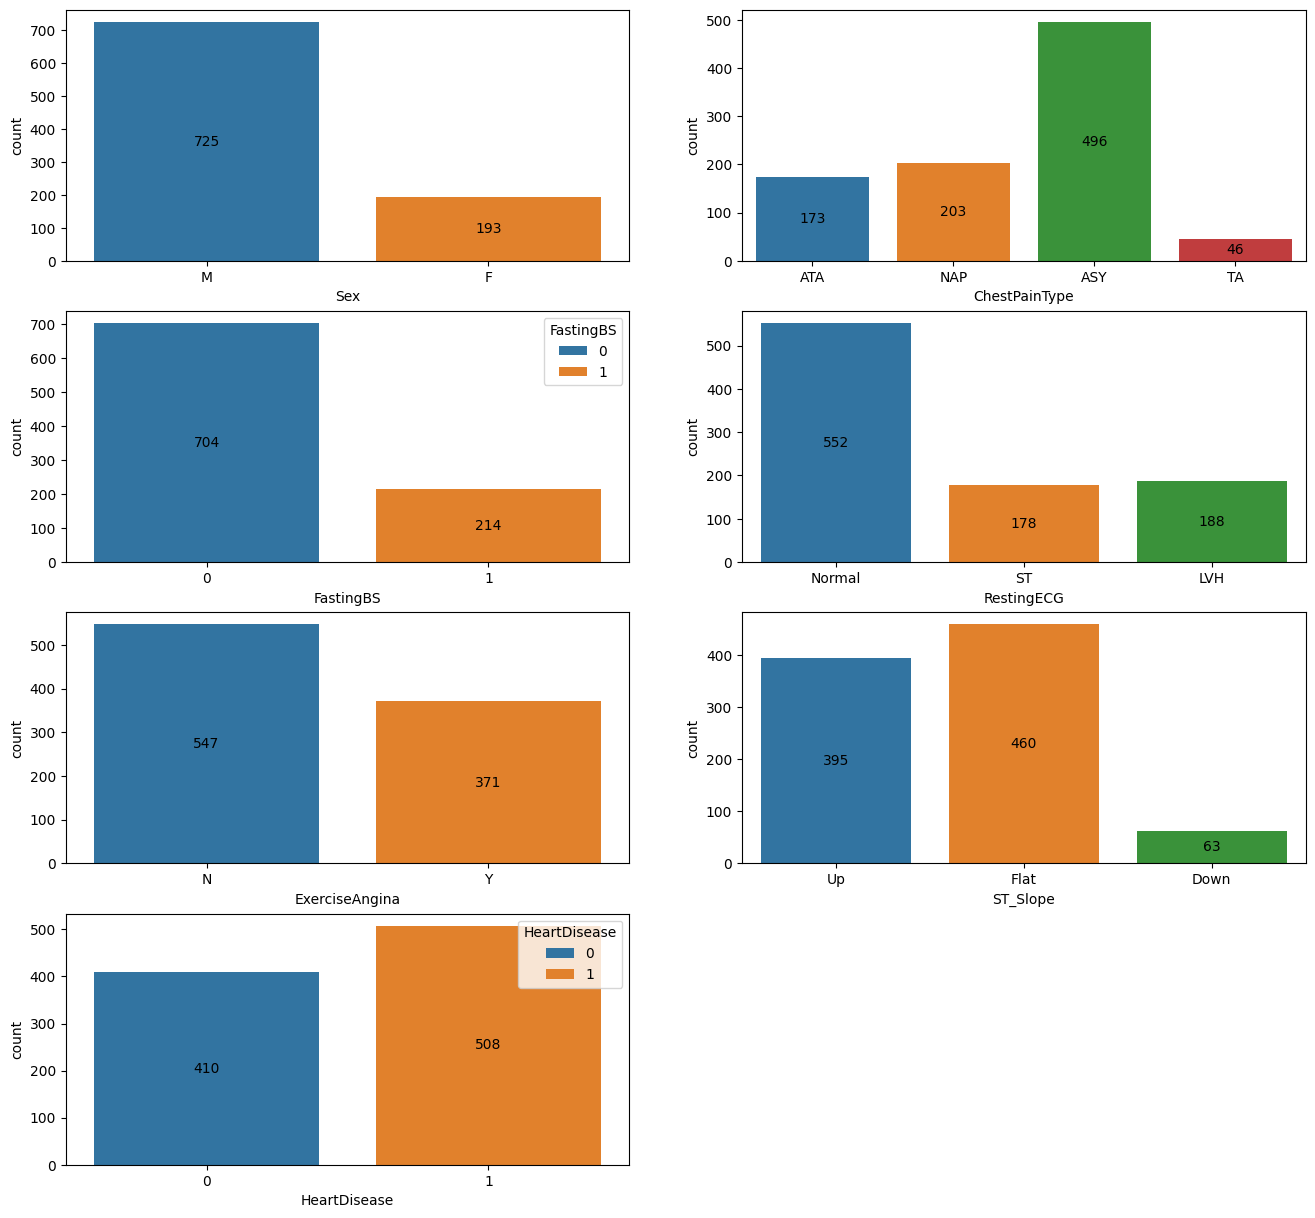

In [50]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16, 15))

for i, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, i + 1)
    colours = []
    sns.countplot(x=df[col], ax=ax, hue=df[col])
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- Dataset is highly skewed towards male patients. There are 725 males and 193 females, which could include a bias in our model.
- 496 patients had ASY (asymptotic) chest pain type.
- 552 patients had a normal resting ECG.
- 704 patients had blood sugar lower than 120 mg/dl.

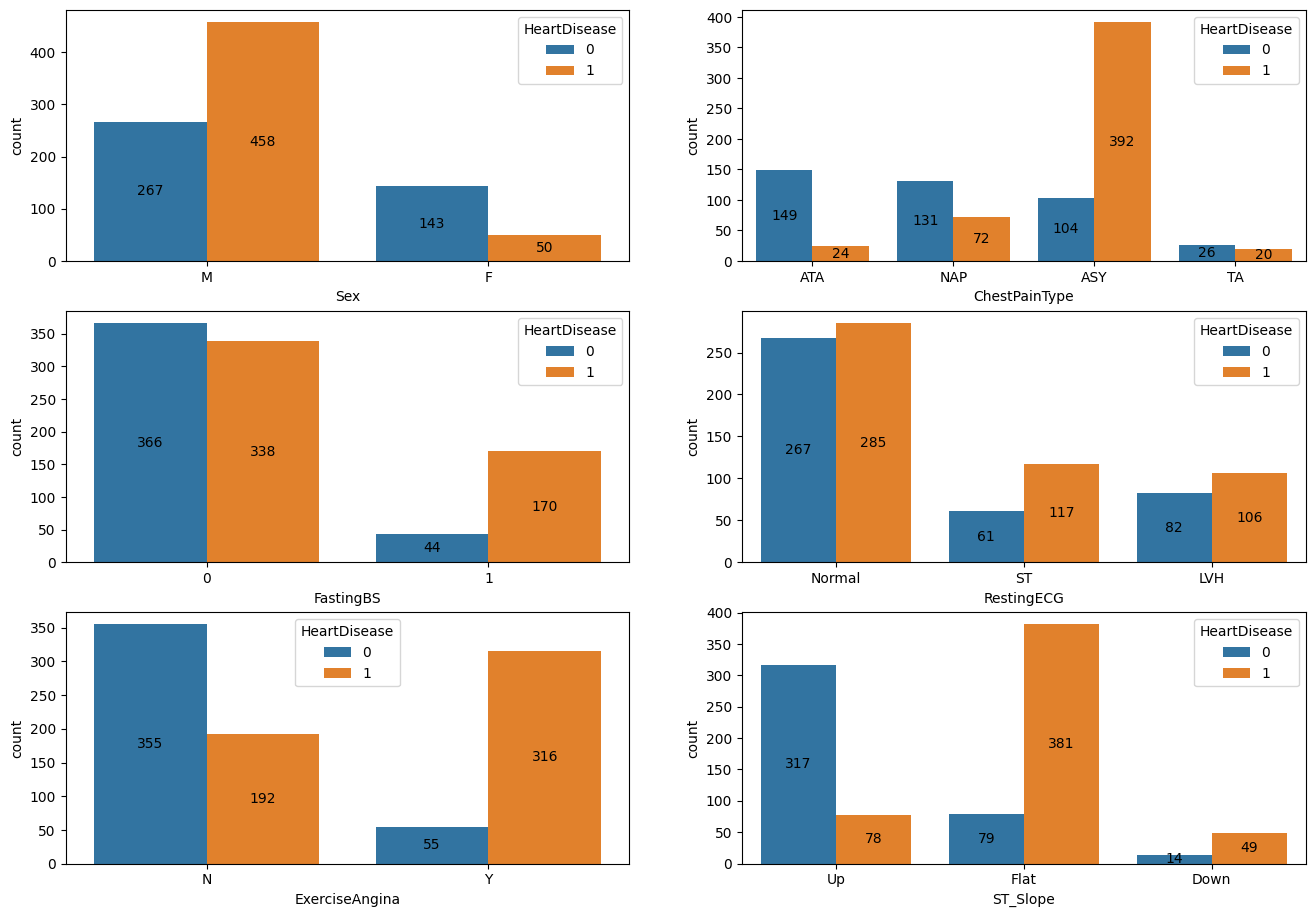

In [12]:
fig = plt.figure(figsize=(16, 15))

for i, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, i + 1)
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- We can notice further how skewed the dataset is towards males with only 50 females being diagnosed with heart disease.
- A significant amount of patients (392) diagnosed with heart disease have asymptomatic (ASY) chest pain.
- A high number of patients (170) with blood sugar levels greater than 120mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such (44).
- Out of all patients who had exercise-induced angina, 316 were diagnosed with heart disease.
- Out of all patients with fat ST slope, 381 were diagnosed with heart disease.

In [13]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,OldPeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [14]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,OldPeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


RestingBP only has one zero value, so we can remove that row from consideration.
Cholesterol has 172 zero values, which is relatively high, so we cannot remove them all. So we will replace all zero values for patients who were diagnosed with heart disease with the median of the non-zero patients diagnosed with heart disease, and the same for patients who were not diagnosed with heart disease.

In [15]:
df_clean = df.copy()

df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"] == 0
cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

df_clean[["RestingBP", "Cholesterol"]].describe()

,RestingBP,Cholesterol
count,917.000000,917.000000
mean,132.540894,239.700109
std,17.999749,54.352727
min,80.000000,85.000000
25%,120.000000,214.000000
50%,130.000000,225.000000
75%,140.000000,267.000000
max,200.000000,603.000000


Minimum values have cahnged for both RestingBP and Cholesterol, therefore there are no more zero values.

In [16]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,OldPeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


<Axes: >

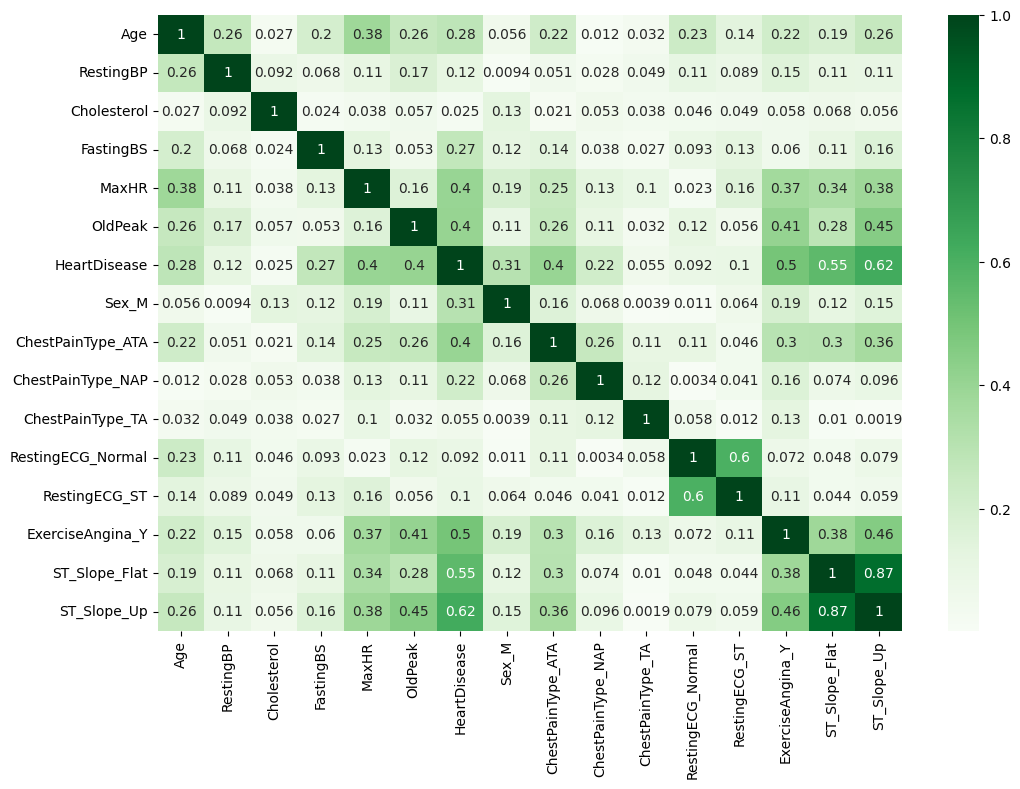

In [17]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap="Greens")

<Axes: >

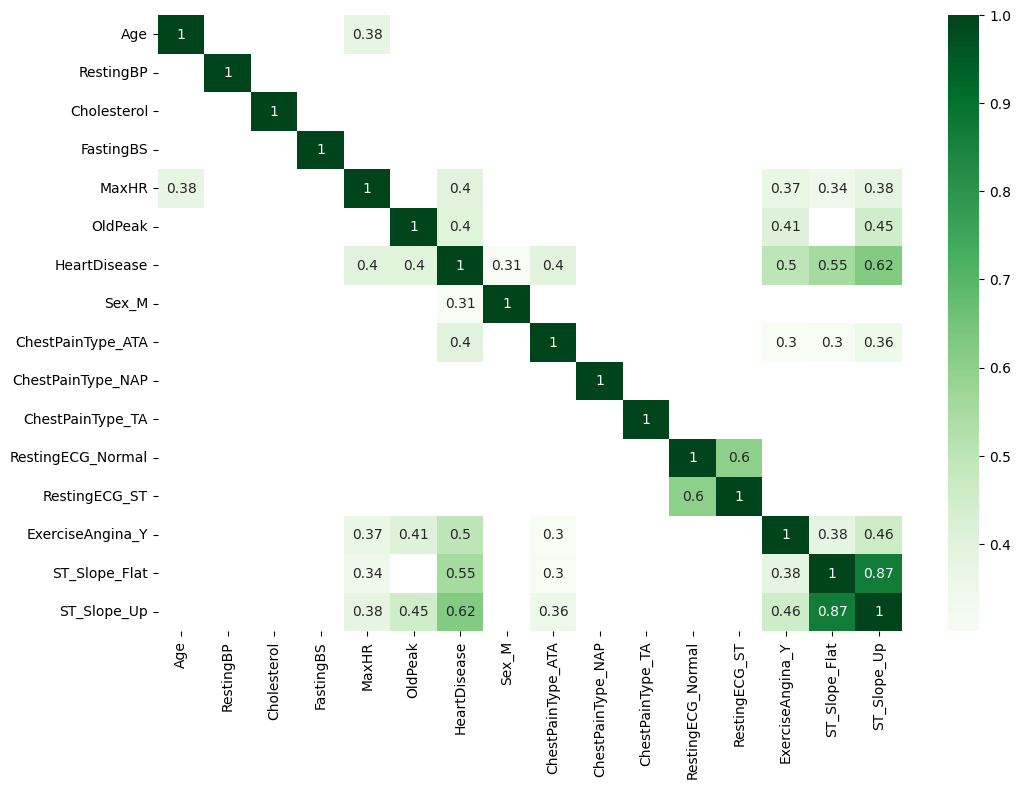

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Greens")

From our correlation heatmap, the following features are positively correlated (correlation coefficient greater than 0.3) to Heart Disease:
- MaxHR (0.4)
- OldPeak (0.4)
- Sex_M (3.1)
- ChestPainType_ATA (0.4)
- ExerciseAngina_Y (0.5)
- ST_Slope_Flat (0.55)
- ST_Slope_Up (0.62)

Suprisingly cholesterol is nto strongly correlated (0.025) to heart disease.

Features Narrowed Down:
- OldPeak
- Sex_M 
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

In [21]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, random_state = 417)

features = ["OldPeak", "Sex_M", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]

In [24]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {round(accuracy*100, 2)}%")


The k-NN classifier trained on OldPeak and with k = 3 has an accuracy of 58.7%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 61.59%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 55.07%


Best performing model had an accuracy of ~82%, was trained on the ST_Slope_Flat feature with ExerciseAngina_Y being a close second. Which corresponds with what we saw in the data distributions.

In [27]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [30]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {round(accuracy*100, 2)}%")

Accuracy: 83.33%


The models accuracy increased to ~83% which is not a significant improvement, but using all features resulted in an improved model.

In [43]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 417)

features = ["OldPeak", "Sex_M", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

In [ ]:
grid_params = {"n_neighbors": range(1, 20), 'metric': ["minkowski", "manhatten"]
               }
               
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'metric': ['minkowski', 'manhatten'], 'n_neighbors': range(1, 20)}, scoring='accuracy')

In [36]:
knn_grid.best_score_*100, knn_grid.best_params_

(np.float64(83.43507030603806), {'metric': 'minkowski', 'n_neighbors': 19})

The best model had ~83% with 19 n_neighbors and minkowski as the distance metric.
The accuracy only slighly improved but since GridSearchCV employs a cross-validation approach, it is reasonable to assume that it is a better estimate of how the model performs, compared to the previous models.


In [45]:
X_test_scaled = scaler.transform(X_test[features])

predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f"Model accuracy on test set: {round(accuracy*100, 2)}%")

Model accuracy on test set: 86.96%


The model got an accuracy of ~87%, meaning our model is likely to correctly predict whether a patient is at risk for heart disease (~87% of the time).

The accuracy being higher than our training data's accuracy does raise some concerns.

In [48]:
print("Distribution of patients by their sex in the entire data set:")
print(X.Sex_M.value_counts())

print("Distribution of patients by their sex in the training data set:")
print(X_train.Sex_M.value_counts())

print("Distribution of patients by their sex in the test data set:")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire data set:
Sex_M
True     724
False    193
Name: count, dtype: int64
Distribution of patients by their sex in the training data set:
Sex_M
True     615
False    164
Name: count, dtype: int64
Distribution of patients by their sex in the test data set:
Sex_M
True     109
False     29
Name: count, dtype: int64


- X had 724 males and 193 females.
- X_train had 615 males and 164 females.
- X_test had 109 males and 29 females.

The above data sets have a significantly higher number of male patients than female ones.
The test data set does not have that many female patients, therefore making it understandable that it had a better accuracy on the test set (could still be other factors though).

The final model was trained on the following features:
- OldPeak
- Sex_M
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up
It had a test accuracy of 86.96%, however this may not indicate a well performing model given the data limitations.

Next steps:
- try out different features.
- expand the grid search parameters to identify more optimal hyperparamters.
- explore other algorithms that might perform better than k-NN.
- try and collect more data.